In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score
import warnings
import plotly.express as px
import plotly.graph_objects as go

In [2]:
df = pd.read_csv('./NFLX.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-02-05,262.000000,267.899994,250.029999,254.259995,254.259995,11896100
1,2018-02-06,247.699997,266.700012,245.000000,265.720001,265.720001,12595800
2,2018-02-07,266.579987,272.450012,264.329987,264.559998,264.559998,8981500
3,2018-02-08,267.079987,267.619995,250.000000,250.100006,250.100006,9306700
4,2018-02-09,253.850006,255.800003,236.110001,249.470001,249.470001,16906900


In [3]:
dataset = pd.DataFrame(df.reset_index()["Close"])
data = dataset.values
data = data.astype('float32')

In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

In [5]:
train_size = int(len(data)*0.8)
test_size = len(data)-train_size 
train, test = data[0:train_size,:], data[train_size:len(data),:] 
print(len(train), len(test))

807 202


In [6]:
# function to take 
def create_dataset(dataset, look_back=1):
 dataX, dataY = [], []
 for i in range(len(dataset)-look_back-1):
     a = dataset[i:(i+look_back), 0]
     dataX.append(a)
     dataY.append(dataset[i + look_back, 0])
 return np.array(dataX), np.array(dataY)

# train and test set
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back) 

# reshape the X and y data
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(805, 1, 1) (805,) (200, 1, 1) (200,)


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
trainX = torch.tensor(trainX, dtype=torch.float32).to(device)
trainY = torch.tensor(trainY, dtype=torch.float32).to(device)
testX = torch.tensor(testX, dtype=torch.float32).to(device)
testY = torch.tensor(testY, dtype=torch.float32).to(device)

In [8]:
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
# Define the LSTM Model
class SequentialLSTM(nn.Module):
    def __init__(self, input_size, output_size):
        super(SequentialLSTM, self).__init__()
        self.lstm1 = nn.LSTM(input_size, 128, batch_first=True)
        self.lstm2 = nn.LSTM(128, 64, batch_first=True)
        self.lstm3 = nn.LSTM(64, 32, batch_first=True)
        self.fc1 = nn.Linear(32, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, output_size)
    
    def forward(self, x):
        # LSTM1
        x, _ = self.lstm1(x) 
        
        # LSTM2
        x, _ = self.lstm2(x)  
        # LSTM3
        x, _ = self.lstm3(x)
        
        # Fully connected layers
        x = self.relu(self.fc1(x[:, -1, :]))  # Only take the last time step output
        x = self.fc2(x)
        return x

In [9]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model
input_size = trainX.shape[2]  # Number of features in input
output_size = 1
model = SequentialLSTM(input_size, output_size).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 200
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    # Convert training data to PyTorch tensors and move to the device
    trainX_tensor = torch.tensor(trainX, dtype=torch.float32).to(device)
    trainY_tensor = torch.tensor(trainY, dtype=torch.float32).unsqueeze(1).to(device)
    
    # Forward pass
    outputs = model(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

/tmp/ipykernel_101964/1593840310.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainX_tensor = torch.tensor(trainX, dtype=torch.float32).to(device)
/tmp/ipykernel_101964/1593840310.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  trainY_tensor = torch.tensor(trainY, dtype=torch.float32).unsqueeze(1).to(device)


Epoch [10/200], Loss: 0.1535
Epoch [20/200], Loss: 0.1235
Epoch [30/200], Loss: 0.0866
Epoch [40/200], Loss: 0.0411
Epoch [50/200], Loss: 0.0352
Epoch [60/200], Loss: 0.0289
Epoch [70/200], Loss: 0.0285
Epoch [80/200], Loss: 0.0261
Epoch [90/200], Loss: 0.0240
Epoch [100/200], Loss: 0.0214
Epoch [110/200], Loss: 0.0180
Epoch [120/200], Loss: 0.0139
Epoch [130/200], Loss: 0.0091
Epoch [140/200], Loss: 0.0045
Epoch [150/200], Loss: 0.0016
Epoch [160/200], Loss: 0.0009
Epoch [170/200], Loss: 0.0010
Epoch [180/200], Loss: 0.0009
Epoch [190/200], Loss: 0.0009
Epoch [200/200], Loss: 0.0008


In [10]:
# Predictions
model.eval()
trainPredict = model(trainX).detach().cpu().numpy()
testPredict = model(testX).detach().cpu().numpy()

# Inverse transform predictions and actual values
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY.cpu().numpy().reshape(-1, 1))
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY.cpu().numpy().reshape(-1, 1))

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 12.92 RMSE
Test Score: 13.98 RMSE


In [11]:
# Shift train predictions for plotting
trainPredictPlot = np.empty_like(data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

# Shift test predictions for plotting
testPredictPlot = np.empty_like(data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(data) - 1, :] = testPredict



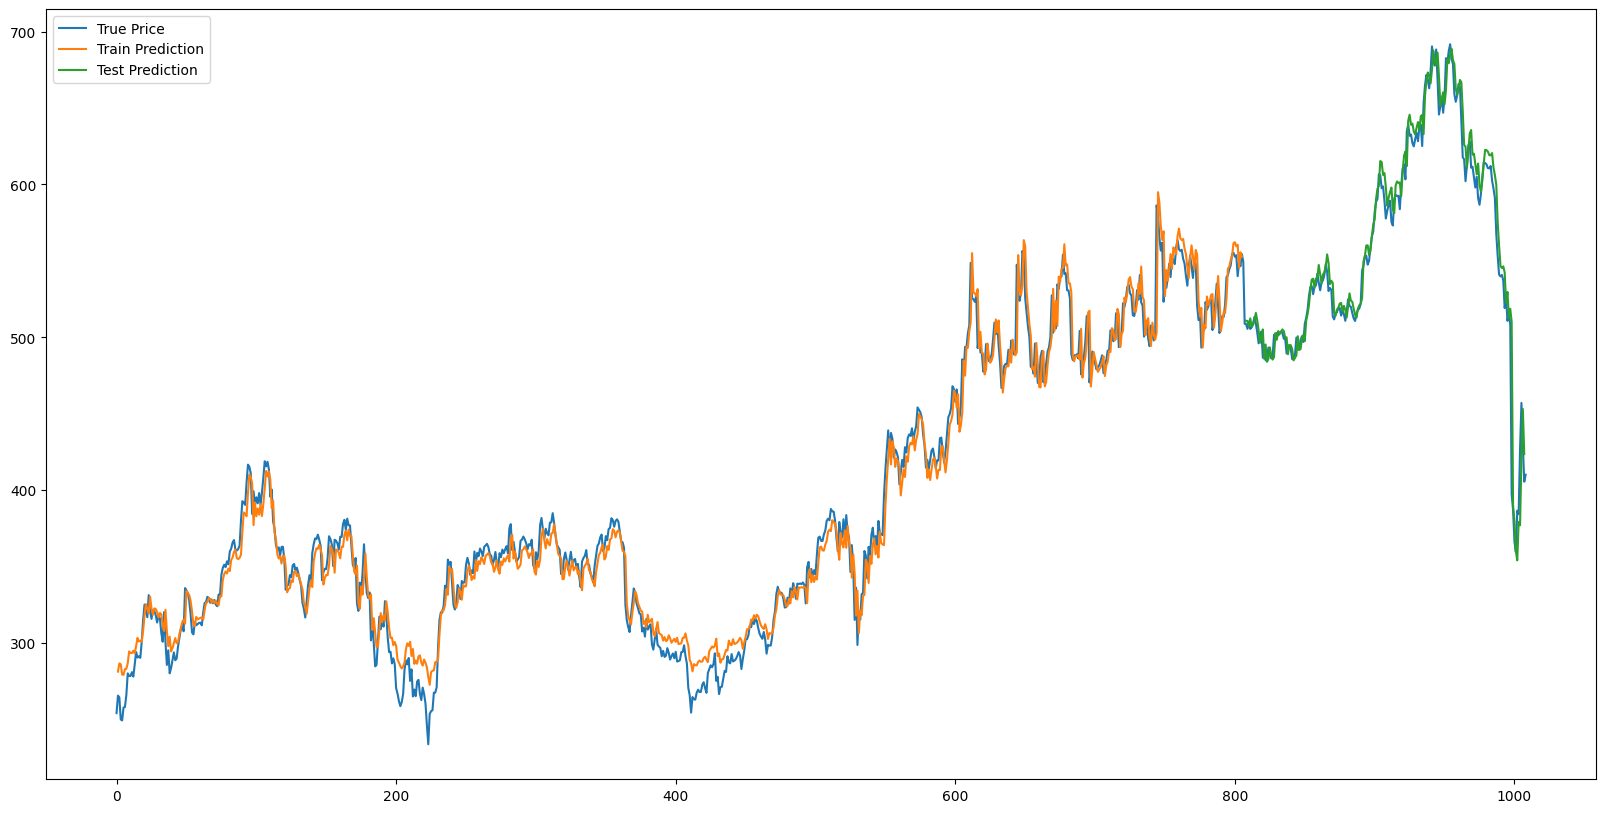

In [12]:
# plot the date, close price and the close price predictions
plt.figure(figsize=(20, 10))
plt.plot(scaler.inverse_transform(data), label='True Price')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.legend()
plt.show();

In [13]:
# Create a DataFrame with the true price (100% of the data)
df_plot = pd.DataFrame(data=scaler.inverse_transform(data), columns=['True Price'])

# Add a column for Test Prediction and fill it with NaN initially
df_plot['Test Prediction'] = np.nan
dates = df['Date'].values
# Find the starting index for test predictions
test_start_index = len(data) - len(testPredict)

# Add the test predictions at the corresponding indices
df_plot.iloc[test_start_index:, 1] = testPredict.flatten()

# Plot using Plotly

fig = go.Figure()

# Add True Price line
fig.add_trace(go.Scatter(
    x=dates, 
    y=df_plot['True Price'], 
    mode='lines', 
    name='Actual Data',
    line=dict(color='yellow')
))

# Add Test Prediction line
fig.add_trace(go.Scatter(
    x=dates, 
    y=df_plot['Test Prediction'], 
    mode='lines', 
    name='Predicted Data (20%)',
    line=dict(color='blue')
))

# Update layout for better appearance
fig.update_layout(
    title='Actual vs Predicted Data (20% Predictions)',
    xaxis_title='Date',
    yaxis_title='Price',
    legend=dict(x=0, y=1),
    template='plotly_dark'
)

# Show the plot
fig.show()


In [14]:
# save the model
torch.save(model.state_dict(), "./models/lstm.pth")